In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [9]:
import numpy as np
import pandas as pd
import re
import string
import emoji
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# Configuration
CONFIG = {
    'vocab_size': 20000,
    'embed_dim': 128,
    'gru_units': 128,
    'dense_units': 64,
    'dropout_rate': 0.5,
    'l2_reg': 0.01,
    'batch_size': 128,
    'epochs': 5,
    'max_seq_len': 150,
    'test_size': 0.2,
    'random_state': 42
}


In [11]:
# Load and Prepare Data
def load_data(filepath):
    df = pd.read_csv(filepath, encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
    df['target'] = df['target'].map({0: 0, 4: 1})  # Convert 4s to 1s
    return df[['text', 'target']]

In [12]:
# Advanced Text Cleaning
def clean_text(text):
    if isinstance(text, float):
        return ""
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Convert emojis to sentiment words
    text = emoji.demojize(text).replace(':', ' ').replace('_', ' ')
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Lowercase and remove extra spaces
    text = text.lower().strip()
    text = re.sub('\s+', ' ', text)
    return text


In [13]:
# Preprocessing Pipeline
def preprocess_data(df):
    # Clean text
    df['clean_text'] = df['text'].apply(clean_text)
    
    # Calculate class weights
    classes = np.unique(df['target'])
    weights = class_weight.compute_class_weight(
        'balanced',
        classes=classes,
        y=df['target']
    )
    class_weights = dict(zip(classes, weights))
    return df, class_weights

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Starting training...
Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 248s 24ms/step - accuracy: 0.7724 - loss: 0.5927 - val_accuracy: 0.8068 - val_loss: 0.4305
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 244s 24ms/step - accuracy: 0.8109 - loss: 0.4269 - val_accuracy: 0.8097 - val_loss: 0.4311
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 244s 24ms/step - accuracy: 0.8171 - loss: 0.4196 - val_accuracy: 0.8177 - val_loss: 0.4167
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 244s 24ms/step - accuracy: 0.8226 - loss: 0.4357 - val_accuracy: 0.8183 - val_loss: 0.4164
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 244s 24ms/step - accuracy: 0.8269 - loss: 0.4005 - val_accuracy: 0.8138 - val_loss: 0.4198
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step

Classification Report:
Accuracy: 0.8183
Precision: 0.8305
Recall: 0.8000
F1 Score: 0.8149

Confusion Matrix:
[[133867  26133]
 [ 31999 128001]]


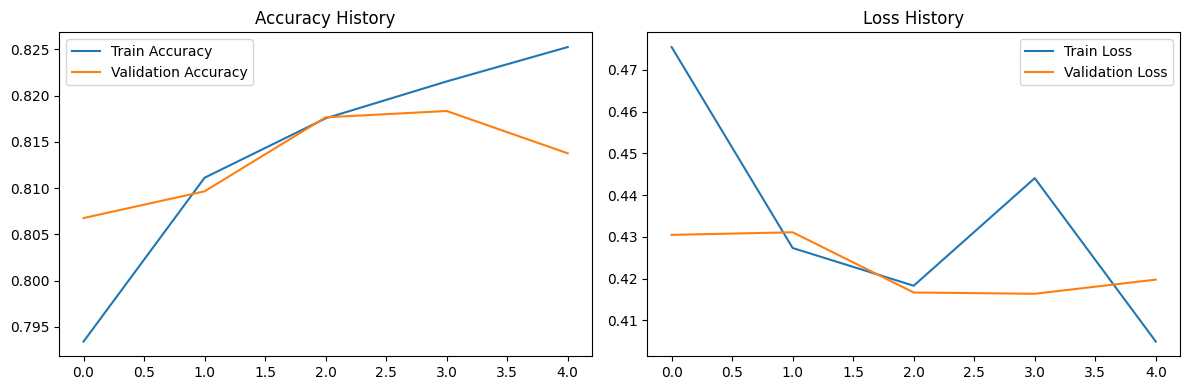


Final Test Accuracy: 0.8183
Final Test Loss: 0.4164


In [14]:
# Main Execution
if __name__ == "__main__":
    # Load and preprocess data
    df = load_data('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv')
    df, class_weights = preprocess_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_text'].values,  # Convert to numpy array
        df['target'].values,
        test_size=CONFIG['test_size'],
        random_state=CONFIG['random_state'],
        stratify=df['target']  # Maintain class distribution
    )
    
    # Tokenization
    tokenizer = Tokenizer(
        num_words=CONFIG['vocab_size'],
        oov_token='<OOV>',
        lower=True
    )
    tokenizer.fit_on_texts(X_train)
    
    # Sequence conversion and padding
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=CONFIG['max_seq_len'], padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=CONFIG['max_seq_len'], padding='post')
    
    # GRU Model Architecture
    model = Sequential([
        Embedding(
            input_dim=CONFIG['vocab_size']+1,
            output_dim=CONFIG['embed_dim'],
            input_length=CONFIG['max_seq_len']
        ),
        Bidirectional(
            GRU(
                CONFIG['gru_units'],
                kernel_regularizer=l2(CONFIG['l2_reg']),
                return_sequences=False
            )
        ),
        Dropout(CONFIG['dropout_rate']),
        Dense(
            CONFIG['dense_units'],
            activation='relu',
            kernel_regularizer=l2(CONFIG['l2_reg'])
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    # Training
    print("\nStarting training...")
    history = model.fit(
        X_train_pad, y_train,
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        validation_data=(X_test_pad, y_test),
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        class_weight=class_weights,
        verbose=1
    )
    
    # Evaluation
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.legend()
    
    plt.tight_layout()
    
    # Get model predictions on test data
    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print("\nClassification Report:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    plt.show()
    
    # Final Evaluation
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    print(f'\nFinal Test Accuracy: {test_acc:.4f}')
    print(f'Final Test Loss: {test_loss:.4f}')